In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from autoplan.trainer import ParserTrainer, ClassEvaluation
from autoplan.token import OCamlTokenizer
from autoplan.vis import plot_accuracy, plot_cm, plot_loss
from autoplan.dataset import TrainVal, RandomSplit, build_synthetic_dataset, set_random_seed
from autoplan.generator import ProgramGenerator
from grammars.rainfall.ocaml2 import Program, Labels
from autoplan.parsing import ProgramParser
from autoplan.neighbors import TokenNNClassifier

from tqdm.auto import tqdm
from scripts.rainfall_ingest import load_full_t1, ingest_dataset, load_new_labels
import torch
import seaborn as sns
from iterextras import par_for
from pickle_cache import PickleCache
from torch import nn
import numpy as np
import dataclasses

pcache = PickleCache()
device = torch.device('cuda:7')

In [3]:
set_random_seed(0)

In [32]:
known_student_dataset = ingest_dataset('T1')
unknown_student_dataset = load_new_labels(known_student_dataset.vocab_index)

Skipped 16 programs


In [40]:
import pandas as pd
df = pd.DataFrame(
    [{'plan': item['labels'].item(), 'where': item['countwhere']} for item in known_student_dataset.dataset])
df

,plan,where
0,2,helper
1,2,helper
2,2,helper
3,2,helper
4,2,helper
5,2,helper
6,2,helper
7,2,helper
8,2,helper
9,2,helper


In [34]:
for item in known_student_dataset.dataset:
    print(item['source'])
    print(item['countwhere'])
    print('='*30 + '\n\n')

let rec rainfall (alof : float list) =
  (let rec sum_helper (alof : float list) (sum : float) (counter : float) =
     (match (alof, counter) with
      | ([], 0.) -> failwith "Empty list."
      | ((-999.)::_, 0.) -> failwith "Empty list."
      | ([], _) -> (sum, counter)
      | ((-999.)::_, _) -> (sum, counter)
      | (hd::tl, _) ->
          if hd >= 0.
          then sum_helper tl (sum +. hd) (counter +. 1.)
          else sum_helper tl sum counter : (float * float)) in
   match sum_helper alof 0. 0. with | (s, c) -> s /. c : float)

helper


let rec rainfall_helper (alon : int list) (sum : int) (num_elements : int) =
  (match alon with
   | [] -> if num_elements = 0 then 0 else sum / num_elements
   | hd::tail ->
       if hd = (-999)
       then (if num_elements = 0 then 0 else sum / num_elements)
       else
         if hd > (-1)
         then rainfall_helper tail (sum + hd) (num_elements + 1)
         else rainfall_helper tail sum num_elements : int)
let rainfall (alon : in

In [7]:
synthetic_dataset = pcache.get('synth_ocaml_data', lambda: build_synthetic_dataset(
    label_set=Labels, 
    N=1000, 
    tokenizer=OCamlTokenizer(), 
    generator=ProgramGenerator(Program()),
    vocab_index=known_student_dataset.vocab_index,
    unique=True),
    force=True)

In [8]:
ds = synthetic_dataset
name_order = sorted(ds.choices.keys(), key=lambda name: ds.choice_indices[name])
for item in synthetic_dataset.dataset:
    for c in item['trace']:
        name = name_order[c.item()]
        if item['choices'][c] >= len(ds.choices[name]):
            raise Exception(name)        

In [10]:
def student_eval(trainer):
    trainer.model.save('parser.pt')
    parser = ProgramParser(Program(), synthetic_dataset, 'parser.pt', device=device, model_opts=model_opts)
        
    def ds_eval(ds):
        pred = []
        true = []
        progs = []
        for batch in ds.loader(ds.dataset):
                for i in range(len(batch['program'])):
                    pred_prog, pred_parse = parser.infer(
                        batch['program'][i].unsqueeze(0), batch['program_len'][i].unsqueeze(0))
                    pred.append(int(pred_parse['strategy'][1]))
                    true.append(batch['labels'][i].item())
                    progs.append(pred_prog)
        return progs, ClassEvaluation.from_preds(true, pred, ['Clean First', 'Clean in SC', 'Single Loop'])
    
    return ds_eval(known_student_dataset), ds_eval(unknown_student_dataset)

In [11]:
model_opts = {
    'model': nn.LSTM,
    'embedding_size': 128,
    'hidden_size': 512
}

trainer = ParserTrainer(
    synthetic_dataset, RandomSplit(synthetic_dataset), device=device, model_opts=model_opts, optim_opts={'lr': 1e-3})

In [12]:
losses = [] 
train_eval = [] 
val_eval = []
kno_eval = []
kno_progs = []
unk_eval = []
unk_progs = []

for _ in tqdm(range(100)):
    loss = trainer.train_one_epoch()
    losses.append(loss)
    train, val = trainer.eval()
    train_eval.append(train)
    val_eval.append(val)
    (kno_prog, kno), (unk_prog, unk) = student_eval(trainer)
    kno_eval.append(kno)
    kno_progs.append(kno_prog)
    unk_eval.append(unk)
    unk_progs.append(unk_prog)

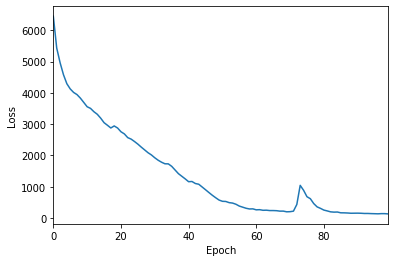

In [13]:
plot_loss(losses)

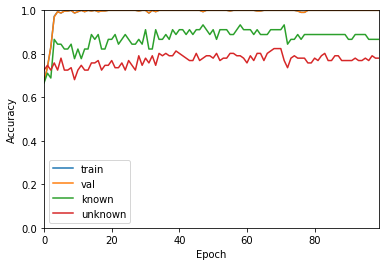

In [14]:
ax = plot_accuracy([t['strategy'] for t in train_eval], label='train')
plot_accuracy([t['strategy'] for t in val_eval], ax=ax, label='val')
plot_accuracy(kno_eval, ax=ax, label='known')
plot_accuracy(unk_eval, ax=ax, label='unknown')
ax.legend()

In [20]:
best_kno_eval = kno_eval[np.argmax([evl.accuracy for evl in kno_eval])]
best_unk_eval = unk_eval[np.argmax([evl.accuracy for evl in unk_eval])]

best_kno_eval.print_incorrect(known_student_dataset)

let rainfall (alon : int list) =
  (let rec rainfallHelp (alon : int list) (nlon : int list) =
     (match alon with
      | [] ->
          (List.fold_right (fun x -> fun y -> x + y) nlon 0) /
            (List.length nlon)
      | hd::tl ->
          (match hd with
           | (-999) ->
               if (List.length nlon) = 0
               then 0
               else
                 (List.fold_right (fun x -> fun y -> x + y) nlon 0) /
                   (List.length nlon)
           | _ ->
               if hd >= 0
               then rainfallHelp tl (hd :: nlon)
               else rainfallHelp tl nlon) : int) in
   rainfallHelp alon [] : int)

Pred: GeneralRainfallLabels.CleanInSC
True: GeneralRainfallLabels.CleanFirst

let rainfall (alon : int list) =
  (let rec rain_helper (alon : int list) (counter : int) (sum : int) =
     (match alon with
      | [] ->
          if counter = 0
          then failwith "No rain was collected"
          else sum / counter
      | hd::tl ->
   

Accuracy: 0.9333333333333333


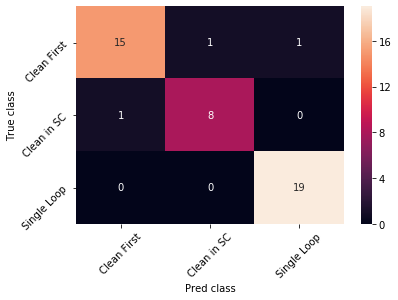

In [27]:
print('Accuracy:', best_kno_eval.accuracy)
best_kno_eval.plot_cm(normalize=False)

Accuracy 0.8241758241758241


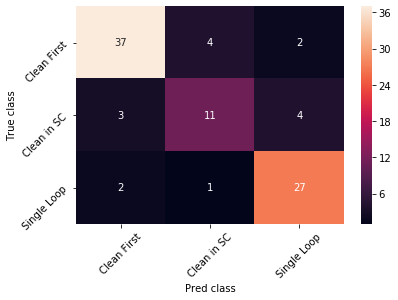

In [26]:
print('Accuracy', best_unk_eval.accuracy)
best_unk_eval.plot_cm(normalize=False)

In [17]:
(kno_progs2, kno_eval2), _ = student_eval(trainer)

In [18]:
for i in kno_eval2.incorrect():
    print('Pred: {}\nTrue: {}\n'.format(str(Labels(kno_eval2.pred[i])), str(Labels(kno_eval2.true[i]))))
    print(known_student_dataset.dataset[i]['source'])
    print('='*30)
    print(OCamlTokenizer().tokenize(kno_progs2[i])[1])
    print('\n\n\n')

Pred: GeneralRainfallLabels.CleanFirst
True: GeneralRainfallLabels.SingleLoop

let rec rainfall_help (alon : float list) (k : float) =
  (match alon with
   | [] -> (0., k)
   | hd::tl ->
       (match hd with
        | (-999.) -> (0., k)
        | n when n >= 0. ->
            (match rainfall_help tl (k +. 1.) with | (s, n) -> ((hd +. s), n))
        | n when n < 0. -> (match rainfall_help tl k with | (s, n) -> (s, n))) : 
  (float * float))
let rainfall (alon : float list) =
  (match rainfall_help alon 0. with
   | (0., 0.) -> 0.
   | (sum, num) -> sum /. num : float)

let rec helper_name (list_name : float list) =
  (match list_name with
   | []|(-999) -> []
   | (-999) -> []
   | tail ->
       if head >= 0. then helper_name tail else head :: (helper_name tail) : 
  float list)
let rec rainfall (list_name : float list) =
  (if (List.length (helper_name list_name)) = 0.
   then 0.
   else addition_var /. counter_var : float)





Pred: GeneralRainfallLabels.SingleLoop
True: GeneralR